# Predicting customer exit - ML models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf

In [2]:
train_df = pd.read_csv('train_prep.csv', index_col = 'id')
test_df = pd.read_csv('test_prep.csv', index_col = 'id')

### Logit

In [46]:
mod = smf.logit(formula = "Exited ~ CreditScore + CreditScore_bracket + Age + Age_bracket + Balance + Balance_positive + EstimatedSalary + Salary_bracket + Geography + Gender + Tenure + NumOfProducts + HasCrCard + IsActiveMember",
                 data = train_df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.385889
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Exited   No. Observations:               165034
Model:                          Logit   Df Residuals:                   165010
Method:                           MLE   Df Model:                           23
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.2523
Time:                        14:41:04   Log-Likelihood:                -63685.
converged:                       True   LL-Null:                       -85169.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.0780      0.157     -6.888      0.000      -1.385      -0.771
CreditScore_bracket[T.(500, 600]]      0.1575      0.050      3.142      0.002       0.059       0.256
CreditScore_bracket[T.(600, 700]]      0.1463      0.065      2.242      0.025       0.018       0.274
CreditScore_bracket[T.(700, 800]]      0.2346      0.084      2.800      0.005       0.070       0.399
CreditScore_bracket[T.(800, 851]]      0.3953      0.112      3.518      0.000       0.175       0.616
Age_bracket[T.(25, 35]]               -0.6482      0.050    -13.014      0.000      -0.746      -0.551
Age_bracket[T.(35, 45]]               -0.3092      0.060     -5.197      0.000      -0.426      -0.193
Age_bracket[T.(45, 55]]                0.6039      0.077      7.841      0.000       0.453       0.755
Age_bracket[T.(55, 100]]              -0.5201      0.104     -4.997      0.000      -0.724      -0.316
Salary_bracket[T.(100000, 150000]]     0.2200      0.057      3.882      0.000       0.109       0.331
Salary_bracket[T.(150000, 200000]]     0.3672      0.078      4.687      0.000       0.214       0.521
Salary_bracket[T.(50000, 100000]]      0.1082      0.036      3.044      0.002       0.039       0.178
Geography[T.Germany]                   1.1478      0.020     56.039      0.000       1.108       1.188
Geography[T.Spain]                     0.0295      0.019      1.580      0.114      -0.007       0.066
Gender[T.Male]                        -0.6574      0.014    -46.271      0.000      -0.685      -0.630
CreditScore                           -0.0014      0.000     -5.171      0.000      -0.002      -0.001
Age                                    0.0733      0.002     30.734      0.000       0.069       0.078
Balance                             3.972e-07   3.96e-07      1.003      0.316   -3.79e-07    1.17e-06
Balance_positive                      -0.3177      0.052     -6.155      0.000      -0.419      -0.217
EstimatedSalary                    -1.551e-06   5.08e-07     -3.053      0.002   -2.55e-06   -5.55e-07
Tenure                                -0.0154      0.003     -6.111      0.000      -0.020      -0.010
NumOfProducts                         -0.8906      0.014    -64.000      0.000      -0.918      -0.863
HasCrCard                             -0.1587      0.016     -9.793      0.000      -0.190      -0.127
IsActiveMember                        -1.2373      0.015    -81.442      0.000      -1.267      -1.208
======================================================================================================
"""

In [48]:
target = 'Exited'
features = train_df.columns.tolist()
features.remove(target)
add_features = "+".join(features)

All features apart from the Balance are statistically significant. Now let's perform cross validation.

In [51]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def CVTest(nFolds = 5, randomState=2137, debug=False):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lists for storing results
    testAUCResults = []
    trainAUCResults = []
    #testACCResults = []
    #trainACCResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(train_df.index.values):
        
        # Model estimation
        mod = smf.logit(formula = "Exited ~ " + add_features, data = train_df.iloc[train])
        res = mod.fit()
        predsTrain = res.predict()
        predsTest = res.predict(train_df.iloc[test])
        
        # Predictions for given fold
        predictions.append(predsTest.values.tolist().copy())
        
        # With indices from original dataset
        indices.append(train_df.iloc[test].index.values.tolist().copy())
        
        # Predictions in [0,1] for accuracy score
        # cutoff = 0.5
        # predsTrain_binary = pd.Series([1 if x > cutoff else 0 for x in predsTrain], name = 'predsTrain_binary')
        # predsTest_binary = pd.Series([1 if x > cutoff else 0 for x in predsTest], name = 'predsTest_binary')
        
        # auc and accuracy score for train and test samples
        trainAUCScore = roc_auc_score(train_df[target].iloc[train], predsTrain)
        testAUCScore = roc_auc_score(train_df[target].iloc[test], predsTest)
        #trainACCScore = accuracy_score(titanic['Survived'].iloc[train], predsTrain_binary)
        #testACCScore = accuracy_score(titanic['Survived'].iloc[test], predsTest_binary)
        
        # Storing auc and accuracy scores
        trainAUCResults.append(trainAUCScore)
        testAUCResults.append(testAUCScore)
        #trainACCResults.append(trainACCScore)
        #testACCResults.append(testACCScore)
        
        
        if debug:
            print("Train AUC:", trainAUCScore,
                  "Valid AUC:", testAUCScore)
        
    return trainAUCResults, testAUCResults, predictions, indices

In [52]:
trainAUCResults, testAUCResults, predictions, indices = CVTest()
print('Mean train AUC:', np.mean(trainAUCResults).round(3))
print('Mean test AUC:', np.mean(testAUCResults).round(3))

Optimization terminated successfully.
         Current function value: 0.386629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385793
         Iterations 7
Mean train AUC: 0.825
Mean test AUC: 0.825


In [54]:
resultM1 = {
    "name": "Logit",
    "description":"First logit with all features",
    "testAUCResults":testAUCResults.copy(),
    "testACCResults":testAUCResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

### Random forests

We have transform some categorical features into random forests friendly format (numerical).

In [303]:
train_rf = train_df.copy()
test_rf = test_df.copy()

In [304]:
train_rf['Geography'] = train_rf['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
test_rf['Geography'] = test_rf['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})

train_rf['Gender'] = train_rf['Gender'].map({'Male': 0, 'Female': 1})
test_rf['Gender'] = test_rf['Gender'].map({'Male': 0, 'Female': 1})

train_rf['Age_bracket'] = train_rf['Age_bracket'].map({'(0, 25]': 1, '(25, 35]': 2, '(35, 45]': 3, '(45, 55]': 4, '(55, 100]': 5})
test_rf['Age_bracket'] = test_rf['Age_bracket'].map({'(0, 25]': 1, '(25, 35]': 2, '(35, 45]': 3, '(45, 55]': 4, '(55, 100]': 5})

train_rf['Salary_bracket'] = train_rf['Salary_bracket'].map({'(0, 50000]': 1, '(50000, 100000]': 2, '(100000, 150000]': 3, 
                                                             '(150000, 200000]': 4}) 
test_rf['Salary_bracket'] = test_rf['Salary_bracket'].map({'(0, 50000]': 1, '(50000, 100000]': 2, '(100000, 150000]': 3, 
                                                           '(150000, 200000]': 4})

train_rf['CreditScore_bracket'] = train_rf['CreditScore_bracket'].map({'(349, 500]': 1, '(500, 600]': 2, '(600, 700]': 3, 
                                                             '(700, 800]': 4, '(800, 851]': 5}) 
test_rf['CreditScore_bracket'] = test_rf['CreditScore_bracket'].map({'(349, 500]': 1, '(500, 600]': 2, '(600, 700]': 3, 
                                                           '(700, 800]': 4, '(800, 851]': 5})

In [68]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def CVTestRF(nFolds = 5, randomState=2137, debug=False,  features=features, saveModels = False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testAUCResults = []
    trainAUCResults = []
    predictions = []
    indices = []
    models = []
    
    for train, test in kf.split(train_rf.index.values):
        # Preparing the estimator
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        # Show fuction execution
        if debug:
            print(clf)
        
        # Training the model
        clf.fit(train_rf.iloc[train][features], train_rf.iloc[train][target])

        # Prediction for train and test data
        # Sklearn returns two columns of probs for both classes!
        predsTrain = clf.predict_proba(train_rf[features].iloc[train])[:,1]
        predsTest = clf.predict_proba(train_rf[features].iloc[test])[:,1]
        #predsTrain_binary = clf.predict(train_rf[features].iloc[train])
        #predsTest_binary = clf.predict(train_rf[features].iloc[test])
        
        # Storing test predictions for each fold
        predictions.append(predsTest.tolist().copy())
        
        # With indices
        indices.append(train_rf.iloc[test].index.tolist().copy())
        
        # Metrics for each fold
        trainAUCScore = roc_auc_score((train_rf[target].iloc[train]), predsTrain)
        testAUCScore = roc_auc_score((train_rf[target].iloc[test]), predsTest)
        
        # Storing results
        trainAUCResults.append(trainAUCScore)
        testAUCResults.append(testAUCScore)
        
        # Optional show results
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
            
        # Optional save models
        if saveModels:
            models.append(clf)
        
    return trainAUCResults, testAUCResults, predictions, indices, models

In [74]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators = 10, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults).round(3))
print('Mean test AUC:', np.mean(testAUCResults).round(3))

Mean train AUC: 0.999
Mean test AUC: 0.845


**Hyperparameters tuning**

In [77]:
# max depth 
for k in range(2,16,2):
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=10, max_depth=k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

2 0.8225503604119169 0.8223492464450342
4 0.8624374911083754 0.8620383948581509
6 0.8785067448242992 0.8769211729060835
8 0.8863080396396384 0.8812779065700138
10 0.8969738914445318 0.8836184873887143
12 0.9145368916887154 0.8827695732469973
14 0.9383160108948949 0.8792339003901322


In [79]:
# min samples split
for k in range(2,16,2):
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=10, max_depth=10, min_samples_split=k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

2 0.8969738914445318 0.8836184873887143
4 0.8971066995672106 0.8842983316869978
6 0.896712986245565 0.8839351778603419
8 0.8965513502877 0.8837850062521795
10 0.8961104603990815 0.883885812278575
12 0.8960372052936967 0.8841860174864669
14 0.8958713963649195 0.8838199550219439


In [84]:
# min samples leaf
for k in range(2,10,2):
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=10, max_depth=10, min_samples_split=4, 
                                                                             min_samples_leaf=k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

2 0.8965545640876338 0.8839322741652106
4 0.8963531438308341 0.8845078253311052
6 0.8956315533347293 0.8839378817824762
8 0.895302763976437 0.8840337678787933


In [85]:
# max features
for k in range(2, len(features) + 1,2):
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=10, max_depth=10, min_samples_split=4, 
                                                                             min_samples_leaf=4, max_features = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

2 0.8907475111828507 0.878429688296848
4 0.8982647418162142 0.8852137304856299
6 0.901184646482444 0.8861319649210682
8 0.9019012949161782 0.8861489303569507
10 0.9031787807408376 0.8854311951207429
12 0.9035489752090058 0.885568867779762
14 0.9038052415831498 0.8850124625779985


In [86]:
# n_estimators
for k in [10,25,50,75,100]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=k, max_depth=10, min_samples_split=4, 
                                                                             min_samples_leaf=4, max_features = 8)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

10 0.9019012949161782 0.8861489303569507
25 0.9029375564314199 0.8870382125987625
50 0.9034768496574038 0.8874070228524376
75 0.9036264700025015 0.8875034190279838
100 0.9036865927261795 0.887563384334135


Random search 

In [89]:
import random
results=[]
paramList = []
for x in range(100):
    params = (random.randint(8, 12), random.randint(4, 12), random.randint(4, 10), random.randint(5, 10), 
              random.randint(10, 50))
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(
        max_depth=params[0],
        min_samples_split = params[1],
        min_samples_leaf=params[2],
        max_features=params[3],
        n_estimators=params[4]
    )
    results.append(np.mean(testAUCResults))
    paramList.append(params)

In [90]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.8876801704397458, (10, 5, 8, 5, 41))
(0.8876438446407745, (9, 9, 6, 6, 38))
(0.887636886834296, (10, 9, 10, 6, 41))
(0.8875894579294025, (9, 12, 7, 7, 35))
(0.8875736212090132, (9, 8, 9, 5, 39))
(0.8875704125195766, (9, 5, 10, 8, 40))
(0.8875597857310268, (9, 7, 7, 9, 43))
(0.8875580623045852, (9, 12, 7, 9, 50))
(0.8875493779949364, (10, 12, 6, 7, 44))
(0.8875233324239085, (10, 6, 10, 6, 30))


**Feature importance**

In [96]:
# n_estimator = 200 - AUC: 0.888

Mean train AUC: 0.9008129969317599
Mean test AUC: 0.8879346126510359


In [97]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=100, max_depth=10, min_samples_split=5, 
                                                                        min_samples_leaf=8, max_features = 5, saveModels = True)

imps = pd.DataFrame({'feature': features, 'feature_importance': models[0].feature_importances_})
imps.sort_values('feature_importance', ascending = False)

[(0.29664165239818924, 'NumOfProducts'),
 (0.24083478700238833, 'Age'),
 (0.1499034981375301, 'Age_bracket'),
 (0.11096048951454493, 'IsActiveMember'),
 (0.057198256092409853, 'Geography'),
 (0.04789470878857603, 'Balance'),
 (0.02737494036666332, 'Gender'),
 (0.017979075441009927, 'EstimatedSalary'),
 (0.017629641079088394, 'Balance_positive'),
 (0.017422348607690284, 'CreditScore'),
 (0.007623697066334311, 'Tenure'),
 (0.0029422316513781775, 'CreditScore_bracket'),
 (0.002902885482391253, 'Salary_bracket'),
 (0.0026917883718058583, 'HasCrCard')]

<Axes: xlabel='feature_importance', ylabel='feature'>

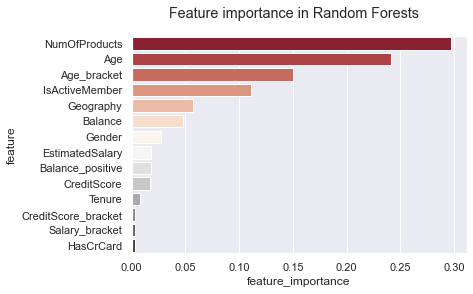

In [110]:
sn.set_theme(style = 'darkgrid')
plt.suptitle('Feature importance in Random Forests')
sn.barplot(data = imps.sort_values('feature_importance', ascending = False), x = 'feature_importance', y = 'feature',
          palette = 'RdGy')

In [111]:
features.remove('CreditScore_bracket')
features.remove('Salary_bracket')

trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=100, max_depth=10, min_samples_split=5, 
                                                                         min_samples_leaf=8, max_features = 5, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults))
print('Mean test AUC:', np.mean(testAUCResults)) # small improvement

In [114]:
features.remove('HasCrCard')

trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=100, max_depth=10, min_samples_split=5, 
                                                                         min_samples_leaf=8, max_features = 5, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults))
print('Mean test AUC:', np.mean(testAUCResults)) # a little bit worse

Mean train AUC: 0.9012782634090962
Mean test AUC: 0.8877025367238243


In [120]:
features.append('HasCrCard')

**Final Random Forests model**

In [122]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestRF(n_estimators=200, max_depth=10, min_samples_split=5, 
                                                                         min_samples_leaf=8, max_features = 5, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5)) 

Mean train AUC: 0.90149
Mean test AUC: 0.88804


In [123]:
resultM2 = {
    "name": "Random Forests",
    "description":"RF after hyperparameters tuning (random search) and feature selection (cs_bracket and salary_bracket removed)",
    "testAUCResults":testAUCResults.copy(),
    "testACCResults":testAUCResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

Submission

In [130]:
clf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=8, max_features = 5)
clf.fit(train_rf[features], train_rf[target])

RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=8,
                       min_samples_split=5, n_estimators=200)

In [135]:
test_rf['Exited'] = clf.predict_proba(test_rf[features])[:,1]
submission = test_rf['Exited']
submission.to_csv('submission_rf.csv')

### XGBoost

In [126]:
import xgboost as xgb

def CVTestXGB(nFolds = 5, randomState=2137, debug=False,  features=features, saveModels = False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testAUCResults = []
    trainAUCResults = []
    predictions = []
    indices = []
    models = []
    
    for train, test in kf.split(train_rf.index.values):
        
        # Preparing the estimator
        bst = xgb.XGBClassifier(*args, **kwargs)
        
        # Show fuction execution
        if debug:
            print(clf)
        
        # Training the model
        bst.fit(train_rf.iloc[train][features], train_rf.iloc[train][target])

        # Prediction for train and test data
        # Sklearn returns two columns of probs for both classes!
        predsTrain = bst.predict_proba(train_rf[features].iloc[train])[:,1]
        predsTest = bst.predict_proba(train_rf[features].iloc[test])[:,1]
        #predsTrain_binary = clf.predict(train_rf[features].iloc[train])
        #predsTest_binary = clf.predict(train_rf[features].iloc[test])
        
        # Storing test predictions for each fold
        predictions.append(predsTest.tolist().copy())
        
        # With indices
        indices.append(train_df.iloc[test].index.tolist().copy())
        
        # Metrics for each fold
        trainAUCScore = roc_auc_score((train_rf[target].iloc[train]), predsTrain)
        testAUCScore = roc_auc_score((train_rf[target].iloc[test]), predsTest)
        
        # Storing results
        trainAUCResults.append(trainAUCScore)
        testAUCResults.append(testAUCScore)
        
        # Optional show results
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
            
        # Optional save models
        if saveModels:
            models.append(bst)
        
    return trainAUCResults, testAUCResults, predictions, indices, models

In [128]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB()
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.91505
Mean test AUC: 0.88643


**Hyperparameters tuning**

In [140]:
# max depth 
for k in range(2,16,2):
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

2 0.8752800230843188 0.8752215131885439
4 0.8863823607563106 0.8857684706069143
6 0.8911165885163335 0.8876619820299932
8 0.9001007512192907 0.8869265750835819
10 0.9190048940663328 0.8836982131692348
12 0.9443037121101533 0.8791701365387299
14 0.9657084470911498 0.874396576943294


In [142]:
# subsample
for k in [0.2,0.4,0.6,0.8,1]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0.2 0.8897121218888275 0.8860789443858448
0.4 0.8906583730371004 0.8872013097365686
0.6 0.8908269079821212 0.8874043053470893
0.8 0.8911029779270407 0.887726507200132
1 0.8911165885163335 0.8876619820299932


In [143]:
# colsample_bytree
for k in [0.2,0.4,0.6,0.8,1]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = 0.8, 
                                                                              colsample_bytree = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0.2 0.8792465328475062 0.8782925161485025
0.4 0.8881600439832535 0.8857633956883303
0.6 0.8900373977890699 0.8870986615197769
0.8 0.8907866202021975 0.8874580049870087
1 0.8911029779270407 0.887726507200132


In [145]:
# colsample_bylevel
for k in [0.2,0.4,0.6,0.8,1]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = 0.8, 
                                                                              colsample_bylevel = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0.2 0.8881543372294727 0.8858559458664118
0.4 0.8903516716210909 0.8874144163745246
0.6 0.8906512336232837 0.8877832492508329
0.8 0.8907277351157725 0.8875938506996086
1 0.8911029779270407 0.887726507200132


In [148]:
# lambda
for k in [0,2,4,6,8,10]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = 0.8, colsample_bylevel = 0.6,
                                                reg_lambda = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0 0.8907694747744953 0.8877181088758572
2 0.8906342340523565 0.887732535714685
4 0.8904780547547417 0.8876468862913682
6 0.8903891674822646 0.8876587433831012
8 0.8903310076204237 0.8877080773029238
10 0.8902354721003075 0.8876435150834915


In [149]:
# learning_rate
for k in [0.2, 0.4, 0.6, 0.8, 1]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = 0.8, 
                                                                              colsample_bylevel = 0.6, reg_lambda = 10, 
                                                                              learning_rate = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0.2 0.8888287501598657 0.8868517557593002
0.4 0.8913971117985472 0.8876609962126805
0.6 0.8927084958436253 0.8871366891753377
0.8 0.8932649597449615 0.8858051816454321
1 0.892996779828311 0.8842178382885573


In [151]:
# min_child_weight
for k in [25,50,75,100,125,150]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = 0.8, 
                                                                              colsample_bylevel = 0.6, reg_lambda = 10, 
                                                                              learning_rate = 0.4, min_child_weight = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

25 0.890877025567311 0.8876526921606797
50 0.8906779782569053 0.8878656966953427
75 0.8903186848532204 0.8877341465267975
100 0.8900999494455568 0.8877647290690026
125 0.8898563560430534 0.887713495686933
150 0.8895771791526638 0.8875730610815257


In [160]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 10, max_depth=6, subsample = 0.8, 
                                                                          colsample_bylevel = 0.6, reg_lambda = 10, 
                                                                          learning_rate = 0.4, min_child_weight = 50)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89068
Mean test AUC: 0.88787


Random Search

In [163]:
import random
results=[]
paramList = []
for x in range(50):
    params = (random.randint(4, 10), random.uniform(0.4, 1), random.uniform(0.6, 1), random.uniform(0.6, 1), 
              random.randint(1, 10), random.uniform(0.1,1), random.randint(1,100), random.randint(1,50))
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(
        max_depth = params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        colsample_bylevel = params[3],
        reg_lambda = params[4],
        learning_rate = params[5],
        min_child_weight = params[6],
        n_estimators = params[7])
    results.append(np.mean(testAUCResults))
    paramList.append(params)

In [164]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.8889663696822483, (6, 0.6426680096317758, 0.7773169503550073, 0.6911868323061576, 5, 0.21218657101684246, 84, 48))
(0.8885888003608585, (4, 0.9206393681546954, 0.7488110708446447, 0.913307958054388, 5, 0.5093488298912029, 32, 46))
(0.8885043117148103, (8, 0.513926967383295, 0.7397378889185717, 0.62654754417932, 7, 0.18123568963786701, 28, 32))
(0.8883569749328964, (10, 0.9931669704732407, 0.6035855182876909, 0.684132442172183, 1, 0.38101308905052855, 82, 29))
(0.8882710657672671, (4, 0.8107192685659, 0.9264611718462551, 0.7727993085330843, 4, 0.4630791132874639, 70, 25))
(0.8881275987208574, (4, 0.7039702632709497, 0.634241988503622, 0.9509845373581743, 6, 0.5416380304843649, 11, 43))
(0.8881231663463464, (4, 0.869519579564744, 0.6262300339891391, 0.6787914179401008, 2, 0.2010024987877997, 71, 38))
(0.887870844879059, (7, 0.6319670792565867, 0.9424539196049495, 0.7617564808023123, 3, 0.3544894036733981, 83, 36))
(0.8878484563611988, (6, 0.9322594749741772, 0.7203219948507028, 0.7203

In [ ]:
features.remove('EstimatedSalary')
features.append('Salary_bracket')
features.remove('Age_bracket')

In [226]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestXGB(n_estimators = 50, max_depth=6, subsample = 0.65, 
                                                                          colsample_bytree = 0.75, colsample_bylevel = 0.7, 
                                                                          reg_lambda = 5, learning_rate = 0.2, 
                                                                          min_child_weight = 85)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89285
Mean test AUC: 0.88912


In [227]:
resultM3 = {
    "name": "XGBoost",
    "description":"XGB after hyperparameters tuning (random search) and feature selection (-age_bracket, salary_bracket for salary)",
    "testAUCResults":testAUCResults.copy(),
    "testACCResults":testAUCResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [223]:
bst = xgb.XGBClassifier(n_estimators = 50, max_depth=6, subsample = 0.65, colsample_bytree = 0.75, colsample_bylevel = 0.7, 
                        reg_lambda = 5, learning_rate = 0.2, min_child_weight = 85)
bst.fit(train_rf[features], train_rf[target])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=85, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: xlabel='feature_importance', ylabel='feature'>

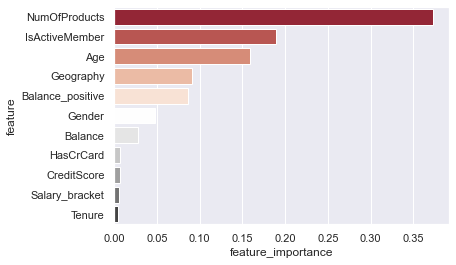

In [224]:
fi_df = pd.DataFrame({'feature': features, 'feature_importance':bst.feature_importances_})
                      
sn.barplot(data = fi_df.sort_values('feature_importance', ascending = False), x = 'feature_importance', y = 'feature',
           palette = 'RdGy')

Submission

In [225]:
test_rf['Exited'] = bst.predict_proba(test_rf[features])[:,1]
submission = test_rf['Exited']
submission.to_csv('submission_xgb.csv')

### Light GBM

In [231]:
import lightgbm as lgb

In [316]:
def CVTestLGB(nFolds = 5, randomState=2137, debug=False,  features=features, saveModels = False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testAUCResults = []
    trainAUCResults = []
    predictions = []
    indices = []
    models = []
    
    for train, test in kf.split(train_rf.index.values):
        
        # Preparing the estimator
        bst = lgb.LGBMClassifier(*args, **kwargs, verbose = -1)
        
        # Show fuction execution
        if debug:
            print(clf)
        
        # Training the model
        bst.fit(train_rf.iloc[train][features], train_rf.iloc[train][target])

        # Prediction for train and test data
        # Sklearn returns two columns of probs for both classes!
        predsTrain = bst.predict_proba(train_rf[features].iloc[train])[:,1]
        predsTest = bst.predict_proba(train_rf[features].iloc[test])[:,1]
        #predsTrain_binary = clf.predict(train_rf[features].iloc[train])
        #predsTest_binary = clf.predict(train_rf[features].iloc[test])
        
        # Storing test predictions for each fold
        predictions.append(predsTest.tolist().copy())
        
        # With indices
        indices.append(train_df.iloc[test].index.tolist().copy())
        
        # Metrics for each fold
        trainAUCScore = roc_auc_score((train_rf[target].iloc[train]), predsTrain)
        testAUCScore = roc_auc_score((train_rf[target].iloc[test]), predsTest)
        
        # Storing results
        trainAUCResults.append(trainAUCScore)
        testAUCResults.append(testAUCScore)
        
        # Optional show results
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
            
        # Optional save models
        if saveModels:
            models.append(bst)
        
    return trainAUCResults, testAUCResults, predictions, indices, models

In [235]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestLGB()
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89714
Mean test AUC: 0.88905


**Iterated Hyperparameter tuning**

In [236]:
# max_depth
for k in range(2,12,2):
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestLGB(max_depth = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

2 0.8845688074194591 0.8841864245642166
4 0.8917175316804495 0.8891756916883435
6 0.8959377833936093 0.8891409785036574
8 0.8966753574946701 0.889153887822968
10 0.8969979907875546 0.8891415919326106


In [244]:
# learning_rate
for k in [0.1,0.2,0.3]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestLGB(max_depth = 4, num_leaves = 2**4, 
                                                                              learning_rate = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0.1 0.8917175316804495 0.8891756916883435
0.2 0.8947432190178208 0.8893450258506286
0.3 0.8969013887784915 0.8888774634278669


In [245]:
# n_estimators
for k in [10,25,50,100,150,200]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestLGB(max_depth = 4, num_leaves = 2**4, 
                                                                              learning_rate = 0.2, n_estimators = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

10 0.8841048454635683 0.8837374976284025
25 0.889168437724573 0.8879493303680027
50 0.8916772863203507 0.8889662909526963
100 0.8947432190178208 0.8893450258506286
150 0.8970956017914983 0.8893728396304417
200 0.8991485256049806 0.8891574601571179


In [246]:
# reg_lambda
for k in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestLGB(max_depth = 4, num_leaves = 2**4, 
                                                                              learning_rate = 0.2, reg_lambda = k)
    print(k, np.mean(trainAUCResults), np.mean(testAUCResults))

0 0.8947432190178208 0.8893450258506286
0.2 0.8946740701616409 0.8892832075569274
0.4 0.8946242310262036 0.8893521025824697
0.6 0.8946109701598395 0.889358872339371
0.8 0.894530714555535 0.8892881042351826
1 0.8944664299141291 0.8893195293074074


In [317]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestLGB(max_depth = 4, num_leaves = 2**4, 
                                                                          learning_rate = 0.2, reg_lambda = 0.6, 
                                                                          saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89461
Mean test AUC: 0.88936


<Axes: xlabel='feature_importance', ylabel='feature'>

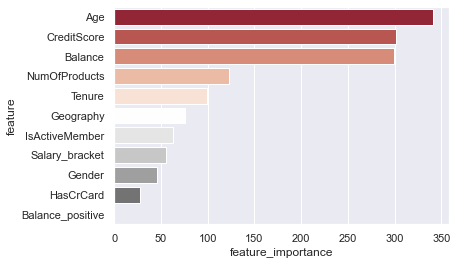

In [254]:
fi_df = pd.DataFrame({'feature': features, 'feature_importance':models[0].feature_importances_})
                      
sn.barplot(data = fi_df.sort_values('feature_importance', ascending = False), x = 'feature_importance', y = 'feature',
           palette = 'RdGy')

In [319]:
resultM4 = {
    "name": "LightGB",
    "description":"LightGB after hyperparameters tuning (iterated) and feature selection",
    "testAUCResults":testAUCResults.copy(),
    "testACCResults":testAUCResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

Submission

In [257]:
bst = lgb.LGBMClassifier(max_depth = 4, num_leaves = 2**4, learning_rate = 0.2, reg_lambda = 0.6, verbose = -1)
bst.fit(train_rf[features], train_rf[target])

LGBMClassifier(learning_rate=0.2, max_depth=4, num_leaves=16, reg_lambda=0.6,
               verbose=-1)

In [261]:
test_rf['Exited'] = bst.predict_proba(test_rf[features])[:,1]
submission = test_rf['Exited']
submission.to_csv('submission_lgbm.csv')

### CatBoost

In [262]:
import catboost as ctb

In [310]:
def CVTestCTB(nFolds = 5, randomState=2137, debug=False,  features=features, saveModels = False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testAUCResults = []
    trainAUCResults = []
    predictions = []
    indices = []
    models = []
    
    for train, test in kf.split(train_rf.index.values):
        
        # Preparing the estimator
        bst = ctb.CatBoostClassifier(*args, **kwargs, verbose = False)
        
        # Show fuction execution
        if debug:
            print(clf)
        
        # Training the model
        bst.fit(train_rf.iloc[train][features], train_rf.iloc[train][target], cat_features = ['Geography'])

        # Prediction for train and test data
        # Sklearn returns two columns of probs for both classes!
        predsTrain = bst.predict_proba(train_rf[features].iloc[train])[:,1]
        predsTest = bst.predict_proba(train_rf[features].iloc[test])[:,1]
        #predsTrain_binary = clf.predict(train_rf[features].iloc[train])
        #predsTest_binary = clf.predict(train_rf[features].iloc[test])
        
        # Storing test predictions for each fold
        predictions.append(predsTest.tolist().copy())
        
        # With indices
        indices.append(train_df.iloc[test].index.tolist().copy())
        
        # Metrics for each fold
        trainAUCScore = roc_auc_score((train_rf[target].iloc[train]), predsTrain)
        testAUCScore = roc_auc_score((train_rf[target].iloc[test]), predsTest)
        
        # Storing results
        trainAUCResults.append(trainAUCScore)
        testAUCResults.append(testAUCScore)
        
        # Optional show results
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
            
        # Optional save models
        if saveModels:
            models.append(bst)
        
    return trainAUCResults, testAUCResults, predictions, indices, models

In [269]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestCTB()
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.90767
Mean test AUC: 0.88875


Hyperparameters - random search

In [276]:
results=[]
paramList = []
for x in range(30):
    params = (random.uniform(0.06,0.1), 100, random.randint(6,12), random.uniform(0.1,1), random.uniform(0.5,1), 
              random.randint(40,90))
    trainAUCResults, testAUCResults, predictions, indices, models = CVTestCTB(
        learning_rate = params[0],
        iterations = params[1],
        depth = params[2],
        subsample = params[3],
        colsample_bylevel = params[4],
        min_data_in_leaf = params[5])
    results.append(np.mean(testAUCResults))
    paramList.append(params)

In [277]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.8890177001229465, (0.09602986793132556, 100, 7, 0.7710843076990721, 0.6560083039928469, 84))
(0.8890040384412068, (0.09985081736926615, 100, 7, 0.5900442459129597, 0.655372635791651, 77))
(0.8889172525148303, (0.08706999423937964, 100, 7, 0.841242250320974, 0.5512065912164843, 48))
(0.8888705489467256, (0.0820509588891083, 100, 8, 0.38691939202970915, 0.8443567915638754, 79))
(0.8888660564257975, (0.0977247835344496, 100, 9, 0.5429918409783541, 0.6827823907378967, 71))
(0.8888654844190423, (0.08898437010036819, 100, 6, 0.279271892954763, 0.9720336172999895, 90))
(0.8888471663190934, (0.09428227764025729, 100, 6, 0.3135667927638809, 0.808265489098204, 65))
(0.888826352827396, (0.07956915680224497, 100, 7, 0.47565083334044056, 0.68954408655643, 50))
(0.8887895632278877, (0.07663400978195203, 100, 7, 0.13327099333222572, 0.9768004104381997, 57))
(0.8887788333945638, (0.08778327559511559, 100, 10, 0.45250355251683705, 0.966551791630766, 75))


In [283]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestCTB(learning_rate = 0.1, iterations = 150, depth = 7,
                                                                          subsample = 0.75, colsample_bylevel = 0.65, 
                                                                          min_data_in_leaf = 80, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89354
Mean test AUC: 0.8893


Finally we can again mess with the features a little bit. Feature importance:

<Axes: xlabel='feature_importance', ylabel='feature'>

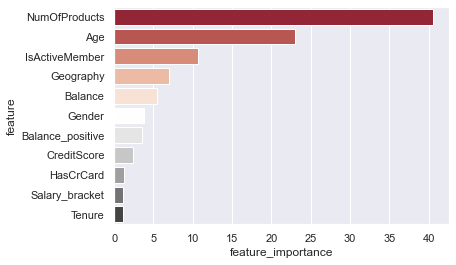

In [284]:
fi_df = pd.DataFrame({'feature': features, 'feature_importance':models[0].feature_importances_})
                      
sn.barplot(data = fi_df.sort_values('feature_importance', ascending = False), x = 'feature_importance', y = 'feature',
           palette = 'RdGy')

In [286]:
features.remove('Salary_bracket')
features.append('EstimatedSalary')

In [293]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestCTB(learning_rate = 0.1, iterations = 150, depth = 7,
                                                                          subsample = 0.75, colsample_bylevel = 0.65, 
                                                                          min_data_in_leaf = 80, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89374
Mean test AUC: 0.88945


So far we treated Geography variable as ordered discrete feature (0,1,2). We can check if the performance will be better if we specify cat_features parameter in the bst.fit() function.

In [311]:
trainAUCResults, testAUCResults, predictions, indices, models = CVTestCTB(learning_rate = 0.1, iterations = 150, depth = 7,
                                                                          subsample = 0.75, colsample_bylevel = 0.65, 
                                                                          min_data_in_leaf = 80, saveModels = True)
print('Mean train AUC:', np.mean(trainAUCResults).round(5))
print('Mean test AUC:', np.mean(testAUCResults).round(5))

Mean train AUC: 0.89317
Mean test AUC: 0.8895


In [312]:
resultM5 = {
    "name": "CatBoost",
    "description":"CatBoost after hyperparameters tuning (random search) and feature selection (estimatedsalary for salary_bracket)",
    "testAUCResults":testAUCResults.copy(),
    "testACCResults":testAUCResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

Submission

In [320]:
bst = ctb.CatBoostClassifier(learning_rate = 0.1, iterations = 150, depth = 7, subsample = 0.75, colsample_bylevel = 0.65, 
                             min_data_in_leaf = 80, verbose = False)
bst.fit(train_rf[features], train_rf[target], cat_features = ['Geography'])

In [322]:
test_rf['Exited'] = bst.predict_proba(test_rf[features])[:,1]
submission = test_rf['Exited']
submission.to_csv('submission_ctb.csv')

**Kaggle AUC Score = 0.88861. Place: 1417/3632 (top40%)**

### Models comparison - ROC AUC Curve

In [326]:
from sklearn.metrics import roc_curve, roc_auc_score

def plotROCs(results):
    
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        # All points needed to draw the curve
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Calculating AUC
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
    
        # Curve weidth
        lw = 1

        # Drawing the curve
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Drawing 45 degree line
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

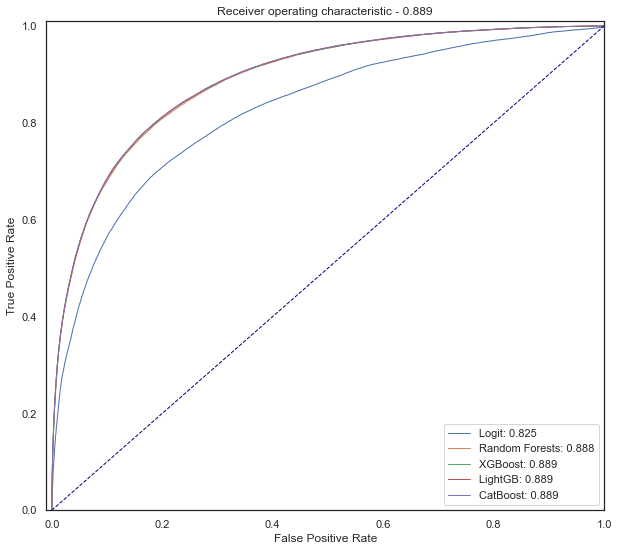

In [336]:
sn.set_theme(style = 'white')
res2plot = []
true = train_df[target].sort_index()
for result in [resultM1, resultM2, resultM3, resultM4, resultM5]:
    # Prediction vector
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
plotROCs(res2plot)